In [1]:
import os
import mir_eval
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
import pickle
from beat_track import beatTracker, Style
from evaluate import evaluate
import beat_track

In [2]:
ANNOTATIONS_DIR = "./annotations"
SOUNDS_DIR = "./BallroomData"

In [3]:
#ballroom dance styles
CHACHA = 'ChaChaCha'
JIVE = 'Jive'
QUICK = 'Quickstep'
RUMBA = 'Rumba'
SAMBA = 'Samba'
TANGO = 'Tango'
VIENNESE = 'Viennese'
WALTZ = 'Waltz'

In [4]:
#mean tempo for each style taken from Krebs 2013
tempo_dict = {}
tempo_dict[CHACHA] = 60.0 / 125.0
tempo_dict[JIVE] = 60.0 / 175.0
tempo_dict[QUICK] = 60.0 / 205.0
tempo_dict[RUMBA] = 60.0 / 100.0
tempo_dict[SAMBA] = 60.0 / 105.0
tempo_dict[TANGO] = 60.0 / 130.0
tempo_dict[VIENNESE] = 60.0 / 180.0
tempo_dict[WALTZ] = 60.0 / 82.0

In [5]:
def danceStyleFromPath(path):
    if CHACHA in path:
        return Style.CHACHA
    elif JIVE in path:
        return Style.JIVE
    elif QUICK in path:
        return Style.QUICK
    elif RUMBA in path:
        return Style.RUMBA
    elif SAMBA in path:
        return Style.SAMBA
    elif TANGO in path:
        return Style.TANGO
    elif VIENNESE in path:
        return Style.VIENNESE
    elif WALTZ in path:
        return Style.WALTZ
    else:
        return None

In [6]:
WINDOW_TIME = 0.023 #23ms, defined in Krebs 2013
HOP_TIME = 0.01 #10ms, defined in Krebs 2013
N_MELS = 82 #Bock 2012
F_MAX = 16000 #Bock 2012
LF_CUTOFF = 250 #Krebs 2013
MVG_AVG_TIME = 1.0 #Krebs 2013
LOG_SCALE = 1 #self-set
L_MIN = 1 #self-set
L_MAX = 501 #self-set
TAU0 = 0.5 #ellis07
STD_TAU = 0.9 #ellis07
WEIGHT = 500 #self-set
SR = 44100

window_len = int(2 ** np.ceil(np.log2(WINDOW_TIME * SR)))
hop_len = int(HOP_TIME * SR)

In [7]:
def parse_annotation(path):
    beat_times, beat_labels = mir_eval.io.load_labeled_events(path)
    db_times = []
    for i in range(len(beat_labels)):
        if beat_labels[i] == '1': #downbeat
            db_times.append(beat_times[i])
    return beat_times, db_times
    
def get_file_data(dir, annotation_dir, ending='.wav', anno_ending='.beats'):
    data = {}
    for root, dirs, files in os.walk(dir):
        for name in files:
            if name.endswith(ending):
                annotation_path = os.path.join(annotation_dir, name[:-4] + anno_ending)
                beat_times, db_times = parse_annotation(annotation_path)
                full_path = os.path.join(root, name)
                style = danceStyleFromPath(full_path)
                data[name] = full_path, beat_times, db_times, style

    return data

In [8]:
dance_data = get_file_data(SOUNDS_DIR, ANNOTATIONS_DIR)
#String(wav_path), List(beat_times), List(db_times), String(style)

In [9]:
example = 'Albums-Fire-08.wav'
example_path = dance_data[example][0]
data, sr = librosa.load(example_path, sr=None)
ipd.display(ipd.Audio(example_path))
style = dance_data[example][3]
print("{} samples @ {} in {} style".format(len(data), sr, style))

beats = dance_data[example][1]
beat_diff = (beats[1:] - beats[:-1])
mean_diff = np.mean(beat_diff)
bpm = (1.0 / mean_diff) * 60
print("Rough tempo estimate: {}".format(bpm))

1354730 samples @ 44100 in Style.CHACHA style
Rough tempo estimate: 123.81596752368064


(82, 3072)


Text(0.5, 1.0, 'Log Mel Spectrogram')

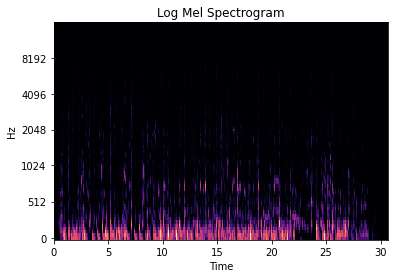

In [10]:
mel = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=hop_len, win_length=window_len, n_mels=N_MELS, fmax=F_MAX)
mel_mag = np.abs(mel)
print(mel_mag.shape)
mel_log = np.log(1 + LOG_SCALE * mel_mag)
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_log, sr=sr, hop_length=hop_len, fmax=F_MAX, x_axis='time', y_axis='mel', ax=ax)
ax.set_title('Log Mel Spectrogram')

In [11]:
lf_logflux = beat_track.logFiltSpecFlux(data, window_len, hop_len, sr, mel_low=True)
hf_logflux = beat_track.logFiltSpecFlux(data, window_len, hop_len, sr, mel_low=False)

Text(0.5, 1.0, 'Low Frequency LogFiltSpecFlux')

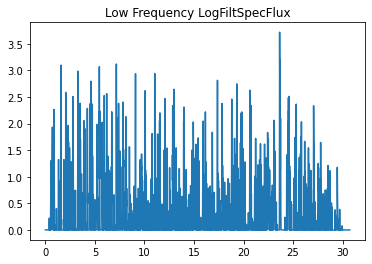

In [12]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0.0, len(data) / sr, len(lf_logflux))
ax.plot(x,lf_logflux)
ax.set_title('Low Frequency LogFiltSpecFlux')

Text(0.5, 1.0, 'High Frequency LogFiltSpecFlux')

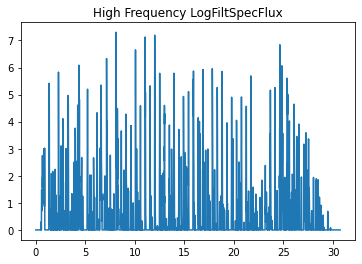

In [13]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(0.0, len(data) / sr, len(hf_logflux))
ax.plot(x,hf_logflux)
ax.set_title('High Frequency LogFiltSpecFlux')

In [14]:
lf_auto = beat_track.autocorrelate_weighted(lf_logflux, hop_dur=HOP_TIME)
hf_auto = beat_track.autocorrelate_weighted(hf_logflux, hop_dur=HOP_TIME)

Tempo Estimate: 122.44897959183673


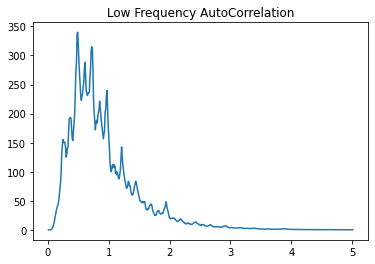

In [15]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(HOP_TIME * L_MIN, HOP_TIME * L_MAX, len(lf_auto))
ax.plot(x, lf_auto)
ax.set_title('Low Frequency AutoCorrelation')
print("Tempo Estimate: {}".format(beat_track.tempo_from_auto(lf_auto, HOP_TIME)))

Tempo Estimate: 122.44897959183673


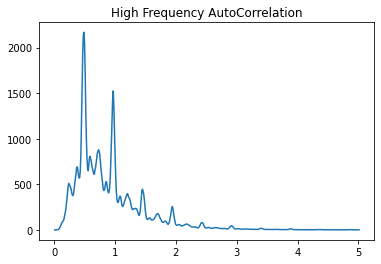

In [16]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(HOP_TIME * L_MIN, HOP_TIME * L_MAX, len(lf_auto))
ax.plot(x, hf_auto)
ax.set_title('High Frequency AutoCorrelation')
print("Tempo Estimate: {}".format(beat_track.tempo_from_auto(hf_auto, HOP_TIME)))

Tempo Estimate: 122.44897959183673


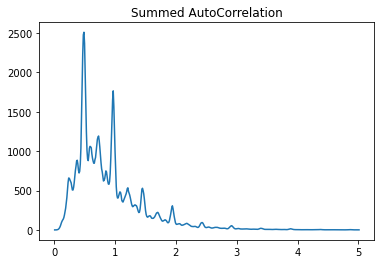

In [17]:
#combine peaks from low and high halfs of spectrum to calculate final tempo
combined_auto = hf_auto + lf_auto
fig = plt.figure()
ax = plt.axes()
x = np.linspace(HOP_TIME * L_MIN, HOP_TIME * L_MAX, len(combined_auto))
ax.plot(x, combined_auto)
ax.set_title('Summed AutoCorrelation')
print("Tempo Estimate: {}".format(beat_track.tempo_from_auto(combined_auto, HOP_TIME)))

1354730 samples @ 44100 in Style.CHACHA style
Global tempo: 122.44897959183673
Found (60,) beats


[Text(0.5, 1.0, 'Ground Truth Beats')]

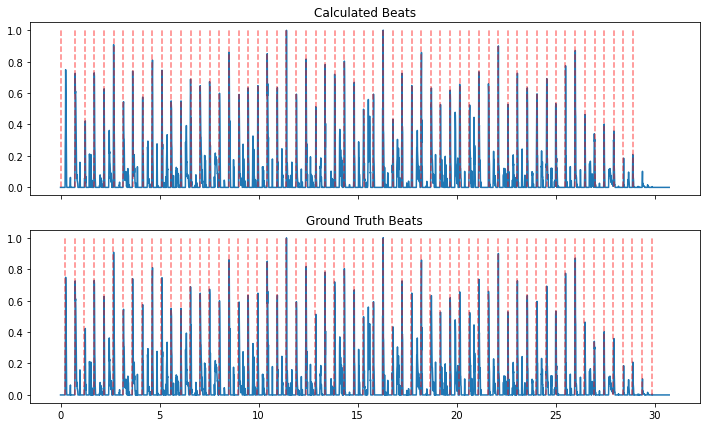

In [18]:
example = 'Albums-Fire-14.wav'
example_path = dance_data[example][0]
data, sr = librosa.load(example_path, sr=None)
ipd.display(ipd.Audio(example_path))
style = dance_data[example][3]
print("{} samples @ {} in {} style".format(len(data), sr, style))

lf_logflux = beat_track.logFiltSpecFlux(data, window_len, hop_len, sr, mel_low=True)
hf_logflux = beat_track.logFiltSpecFlux(data, window_len, hop_len, sr, mel_low=False)
lf_auto = beat_track.autocorrelate_weighted(lf_logflux, hop_dur=HOP_TIME)
hf_auto = beat_track.autocorrelate_weighted(hf_logflux, hop_dur=HOP_TIME)
combined_auto = hf_auto + lf_auto
global_tempo = beat_track.tempo_from_auto(combined_auto, HOP_TIME)

ground_beats = dance_data[example][1]
print("Global tempo: {}".format(global_tempo))

final_beats = beat_track.calculate_beats(hf_logflux, global_tempo)
print("Found {} beats".format(final_beats.shape))

fig, ax = plt.subplots(nrows=2, figsize=(12,7), sharex=True)
x = np.linspace(0.0, len(data) / sr, len(hf_logflux))
ax[0].plot(x, librosa.util.normalize(hf_logflux), label='Onset strength')
ax[0].set(title='Calculated Beats')
ax[0].vlines(final_beats, 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
ax[1].plot(x, librosa.util.normalize(hf_logflux), label='Onset strength')
ax[1].vlines(ground_beats, 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
ax[1].set(title='Ground Truth Beats')

In [19]:
f = IntProgress(min=0, max=len(dance_data)) # instantiate the bar
display(f) # display the bar

# store statistics for each genre separately
style_dict = {}
style_dict[Style.CHACHA] = [0,0,0]
style_dict[Style.JIVE] = [0,0,0]
style_dict[Style.QUICK] = [0,0,0]
style_dict[Style.RUMBA] = [0,0,0]
style_dict[Style.SAMBA] = [0,0,0]
style_dict[Style.TANGO] = [0,0,0]
style_dict[Style.VIENNESE] = [0,0,0]
style_dict[Style.WALTZ] = [0,0,0]

for key in dance_data:
    f.value += 1

    #load file
    path = dance_data[key][0]
    ref_beats = dance_data[key][1]
    style = dance_data[key][3]
    
    #calculate beats
    est_beats,_ = beatTracker(path, danceStyle=style)

    # count hits and misses for each style
    results = evaluate(est_beats, ref_beats)
    style_dict[style][0] += results[0][0]
    style_dict[style][1] += results[0][1]
    style_dict[style][2] += results[0][2]

# calculate overall f_measure for each style
print("F measure performance")
for key in style_dict:
    tc, fp, fn = style_dict[key]
    f_measure = 0
    if(tc + fp + fn > 0):
        f_measure = (2 * tc) / (2 * tc + fn + fp)
    print("{}: {} {} {} {}".format(key, tc, fp, fn, f_measure))

IntProgress(value=0, max=698)

F measure performance
Style.CHACHA: 5117 1353 1519 0.7808637265374637
Style.JIVE: 2943 1579 1943 0.6256377551020408
Style.QUICK: 5401 2518 2874 0.6670371742620723
Style.RUMBA: 2668 1833 2062 0.5780522153612826
Style.SAMBA: 2483 1696 1727 0.5919656693288831
Style.TANGO: 2554 2098 2904 0.505242334322453
Style.VIENNESE: 2900 3188 2852 0.48986486486486486
Style.WALTZ: 1476 2864 3182 0.32807290509002
